<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23093 entries, 0 to 23092
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   State         23093 non-null  object 
 1   District      23093 non-null  object 
 2   Market        23093 non-null  object 
 3   Commodity     23093 non-null  object 
 4   Variety       23093 non-null  object 
 5   Grade         23093 non-null  object 
 6   Arrival_Date  23093 non-null  object 
 7   Min Price     23093 non-null  float64
 8   Max Price     23093 non-null  float64
 9   Modal Price   23093 non-null  float64
dtypes: float64(3), object(7)
memory usage: 1.8+ MB
None
           Min Price      Max Price    Modal Price
count   23093.000000   23093.000000   23093.000000
mean     4187.077045    4976.034260    4602.917742
std      5472.783385    6277.308057    5843.822711
min         0.000000       0.000000       0.830000
25%      1750.000000    2000.000000    1955.000000
50%      272

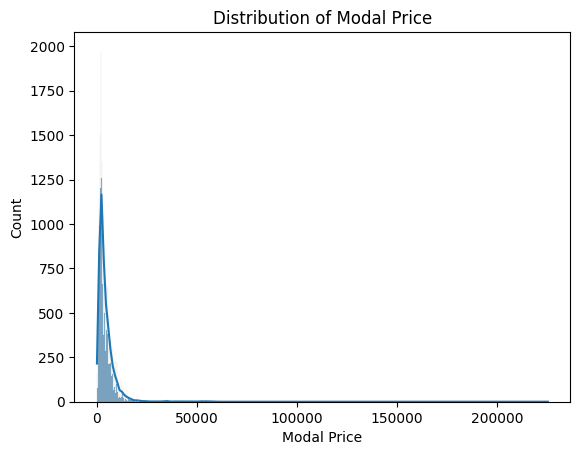

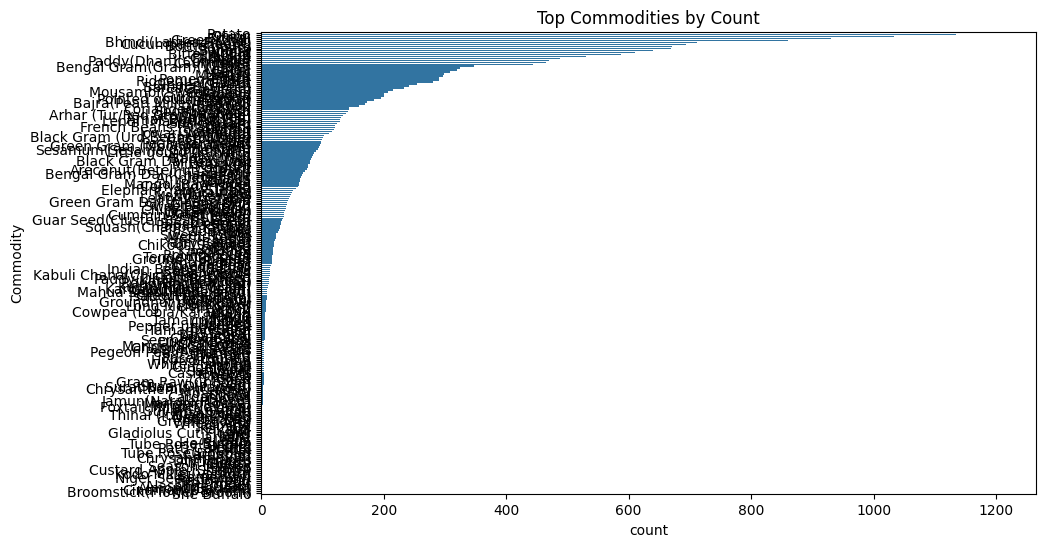

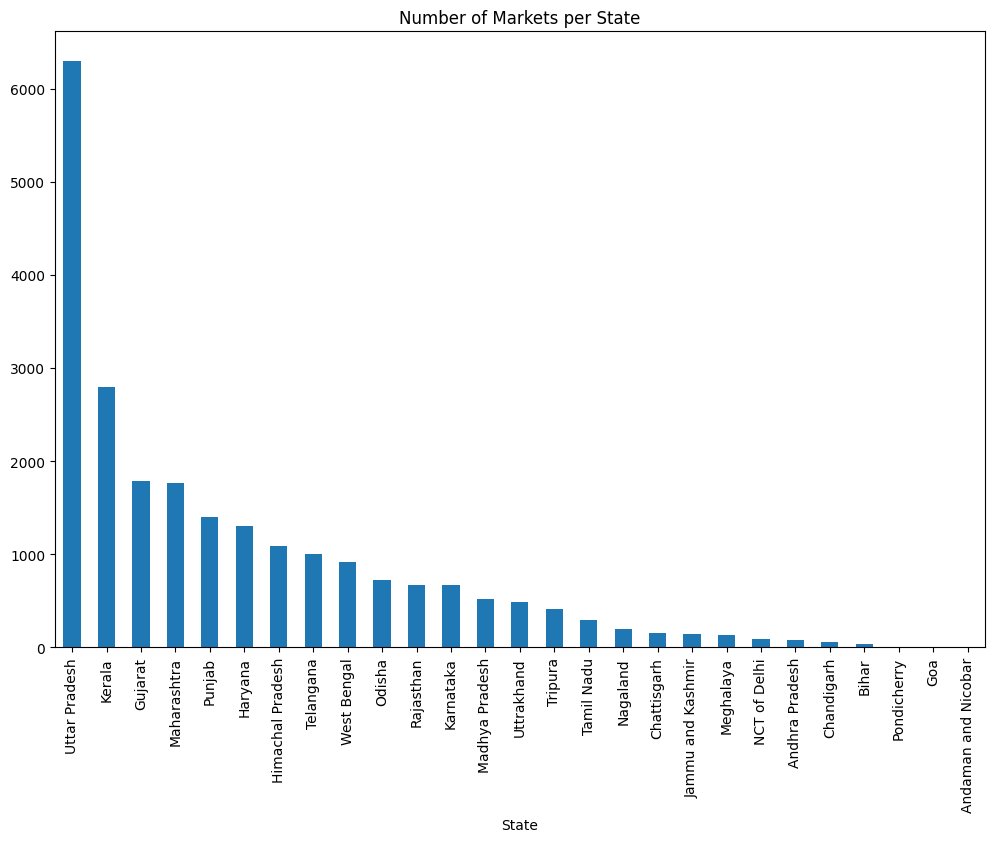

In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('/Users/Rachit Singh/OneDrive/Documents/Price_Agriculture_commodities_Week.csv')

# Display basic information
print(df.info())
print(df.describe())
print(df.head())

# Check for missing values
print(df.isnull().sum())

# Unique values per column
for col in df.columns:
    print(f"{col}: {df[col].nunique()} unique values")

# Visualizations
# Distribution of Modal Price
sns.histplot(df['Modal Price'], kde=True)
plt.title('Distribution of Modal Price')
plt.show()

# Commodity count plot
plt.figure(figsize=(10, 6))
sns.countplot(y='Commodity', data=df, order=df['Commodity'].value_counts().index)
plt.title('Top Commodities by Count')
plt.show()

# State-wise market count
plt.figure(figsize=(12, 8))
df['State'].value_counts().plot(kind='bar')
plt.title('Number of Markets per State')
plt.show()


In [80]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score



# Convert Arrival_Date to datetime
df['Arrival_Date'] = pd.to_datetime(df['Arrival_Date'], format='%d-%m-%Y')

# Extract useful date features
df['Day'] = df['Arrival_Date'].dt.day
df['Month'] = df['Arrival_Date'].dt.month
df['Year'] = df['Arrival_Date'].dt.year

# Drop Arrival_Date as it's no longer needed
df.drop(['Arrival_Date'], axis=1, inplace=True)

# Add feature engineering: Price Range and Average Price
df['Price Range'] = df['Max Price'] - df['Min Price']
df['Average Price'] = (df['Max Price'] + df['Min Price']) / 2

# Handling categorical columns (Only these columns will be one-hot encoded)
categorical_cols = ['State', 'District', 'Market', 'Commodity', 'Variety', 'Grade']
numerical_cols = ['Min Price', 'Max Price', 'Day', 'Month', 'Year', 'Price Range', 'Average Price']

# Define the column transformer with OneHotEncoder for categorical columns and StandardScaler for numerical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),  # Scale numerical columns
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)  # One-hot encode categorical columns
    ])

# Define features (X) excluding the target column 'Modal Price'
X = df.drop(['Modal Price'], axis=1)
y = df['Modal Price']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Dictionary of models
models = {
    "Linear Regression": LinearRegression()
}

# Train and evaluate each model
scores = {}
for name, model in models.items():
    print(f"Training {name}...")
    
    # Create pipeline with preprocessing and model
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    # Fit the model
    pipeline.fit(X_train, y_train)
    
    # Make predictions
    y_pred = pipeline.predict(X_test)
    
    # Evaluation
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    scores[name] = {"RMSE": rmse, "R²": r2}
    
    print(f"{name} - RMSE: {rmse:.4f}, R²: {r2:.4f}")

# Display the evaluation scores for all models
print("\nEvaluation Scores for all models:")
for model_name, score in scores.items():
    print(f"{model_name} - RMSE: {score['RMSE']:.4f}, R²: {score['R²']:.4f}")


Training Linear Regression...
Linear Regression - RMSE: 510.1981, R²: 0.9916

Evaluation Scores for all models:
Linear Regression - RMSE: 510.1981, R²: 0.9916


c:\Users\Rachit Singh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [81]:
import pickle

# Save the Linear Regression model
with open('linear_regression_model.pkl', 'wb') as model_file:
    pickle.dump(models['Linear Regression'], model_file)

print("Linear Regression model saved as 'linear_regression_model.pkl'.")


Linear Regression model saved as 'linear_regression_model.pkl'.


In [82]:
import pickle

# Save the linear regression model
with open('linear_regression_model.pkl', 'wb') as model_file:
    pickle.dump(models["Linear Regression"], model_file)

# Save the OneHotEncoder and StandardScaler from the ColumnTransformer
# Extract the individual transformers
onehot_encoder = preprocessor.named_transformers_['cat']
scaler = preprocessor.named_transformers_['num']

# Save the OneHotEncoder
with open('onehot_encoder.pkl', 'wb') as encoder_file:
    pickle.dump(onehot_encoder, encoder_file)

# Save the StandardScaler
with open('scaler.pkl', 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)

print("Model, OneHotEncoder, and Scaler have been saved successfully!")


Model, OneHotEncoder, and Scaler have been saved successfully!


In [83]:
# Load saved components
with open('linear_regression_model.pkl', 'rb') as model_file:
    loaded_model = pickle.load(model_file)

with open('onehot_encoder.pkl', 'rb') as encoder_file:
    loaded_onehot_encoder = pickle.load(encoder_file)

with open('scaler.pkl', 'rb') as scaler_file:
    loaded_scaler = pickle.load(scaler_file)

print("Loaded model, OneHotEncoder, and Scaler successfully!")


Loaded model, OneHotEncoder, and Scaler successfully!


In [84]:
import os
print(os.getcwd())


c:\Users\Rachit Singh\crop_price_app
